In [1]:
!wget -O arxiv_abs_title.zip "https://zenodo.org/records/3496527/files/gcunhase%2FArXivAbsTitleDataset-v1.0.zip?download=1"
!unzip arxiv_abs_title.zip


--2025-05-10 07:34:54--  https://zenodo.org/records/3496527/files/gcunhase%2FArXivAbsTitleDataset-v1.0.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13098401 (12M) [application/octet-stream]
Saving to: ‘arxiv_abs_title.zip’

arxiv_abs_title.zip 100%[===================>]  12.49M   581KB/s    in 23s     

2025-05-10 07:35:17 (554 KB/s) - ‘arxiv_abs_title.zip’ saved [13098401/13098401]

Archive:  arxiv_abs_title.zip
923c122438b1317f9db090a5858aecb7c9d344f8
   creating: gcunhase-ArXivAbsTitleDataset-923c122/
 extracting: gcunhase-ArXivAbsTitleDataset-923c122/.gitignore  
  inflating: gcunhase-ArXivAbsTitleDataset-923c122/LICENSE  
  inflating: gcunhase-ArXivAbsTitleDataset-923c122/README.md  
   creating: gcunhase-ArXivAbsTitleDataset-923c122/modules/
 extracting: gcunhase-ArXivAbsTitleDataset-923c122/modules

In [2]:
!pip install sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [14]:
import os
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import openai
from rouge_score import rouge_scorer


# 1. Load & Clean Corpus


In [ ]:
base_path = "gcunhase-ArXivAbsTitleDataset-923c122/results"
files = os.listdir(base_path)


In [11]:
data = []
for file in files:
    if file.endswith("_title.txt"):
        # Identify matching abstract file
        abstract_file = file.replace("_title.txt", "_abs.txt")
        category = file.split("_")[0]
        title_path = os.path.join(base_path, file)
        abs_path = os.path.join(base_path, abstract_file)
        if not os.path.exists(abs_path):
            print(f"Abstract file missing for category: {category}")
            continue

        # Read lines
        with open(title_path, "r", encoding="utf-8") as f_titles, \
             open(abs_path, "r", encoding="utf-8") as f_abstracts:
            titles = f_titles.readlines()
            abstracts = f_abstracts.readlines()

        # Ensure both files have the same number of lines
        if len(titles) == len(abstracts):
            for title, abstract in zip(titles, abstracts):
                data.append({
                    "category": category,
                    "title": title.strip(),
                    "abstract": abstract.strip()
                })
        else:
            print(f"Mismatch in file lengths for category: {category}")

df_raw = pd.DataFrame(data)

# Add a unique ID column to each record
df_raw['id'] = df_raw.index + 1

# Clean text fields to strip out any non-UTF8 artifacts
df_raw['title'] = df_raw['title'].str.encode('utf-8', 'ignore').str.decode('utf-8')
df_raw['abstract'] = df_raw['abstract'].str.encode('utf-8', 'ignore').str.decode('utf-8')

# Persist cleaned corpus for future reference
df_raw.to_csv("arxiv_cleaned.csv", index=False)

print(f"Loaded & cleaned {len(df_raw)} documents.")


Loaded & cleaned 39143 documents.


# 2. Chunking Strategy (Sliding‑Window)


In [12]:

def chunk_text(text, window_size=300, stride=150):
    """
    Break a text into overlapping chunks of `window_size` characters,
    stepping by `stride` each time.
    """
    chunks = []
    for i in range(0, len(text), stride):
        chunk = text[i : i + window_size]
        if len(chunk) < window_size:
            break
        chunks.append(chunk)
    return chunks

# Apply chunking to the abstract field
df_raw['chunks'] = df_raw['abstract'].apply(lambda t: chunk_text(t, window_size=300, stride=150))




# 3. Vectorisation with a Different Model


In [19]:
embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

def embed_chunks(chunk_list):
    """
    Compute embeddings for a list of text chunks.
    Returns a numpy array of shape (n_chunks, embedding_dim).
    """
    if not chunk_list:
        return np.array([])
    return embedding_model.encode(chunk_list, convert_to_tensor=False)

# Embed all chunks
df_raw['embeddings'] = df_raw['chunks'].apply(embed_chunks)

# Filter out entries with empty embeddings
df_raw = df_raw[df_raw['embeddings'].apply(lambda x: x.size > 0)].reset_index(drop=True)

# Flatten all embeddings into one big array for retrieval
all_embeddings = np.vstack(df_raw['embeddings'].values)
print("Vectorisation complete. Total chunks:", all_embeddings.shape[0])


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Vectorisation complete. Total chunks: 189128


# 4. Retrieval & Top‑K Recall Plot


In [22]:
# Build a held‑out query set: 50 random abstracts
query_df = df_raw.sample(50, random_state=42).reset_index(drop=True)
query_texts = query_df['abstract'].tolist()

# Pre-embed queries
query_embeddings = embedding_model.encode(query_texts, convert_to_tensor=False)




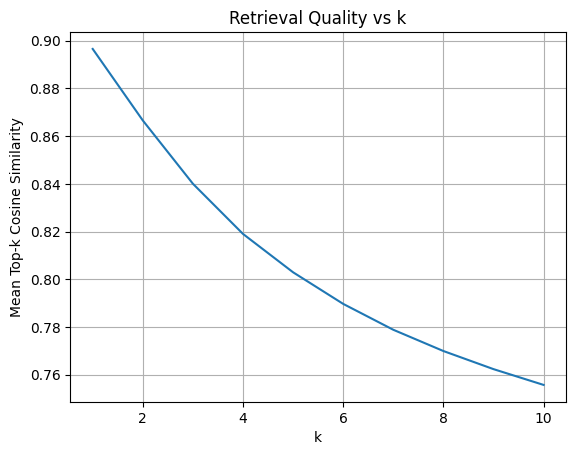

In [21]:
def top_k_recall(query_emb, all_embs, k=5):
    """
    Compute the mean cosine similarity of the top-k most similar embeddings.
    """
    sims = cosine_similarity([query_emb], all_embs)[0]
    topk = np.sort(sims)[-k:]
    return topk.mean()

# Compute recall (mean similarity) for k
k_vals = list(range(1, 11))
recalls = []
for k in k_vals:
    mean_recall = np.mean([top_k_recall(qe, all_embeddings, k) for qe in query_embeddings])
    recalls.append(mean_recall)

plt.figure()
plt.plot(k_vals, recalls)
plt.xlabel('k')
plt.ylabel('Mean Top‑k Cosine Similarity')
plt.title('Retrieval Quality vs k')
plt.grid(True)
plt.show()



In [23]:
import os
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from rouge_score import rouge_scorer
import torch
import random


# 5. Prompt Construction & Generation


In [24]:
gen_model_name = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(gen_model_name)
gen_model = AutoModelForSeq2SeqLM.from_pretrained(gen_model_name)

def generate_answer(context, question, max_len=128):
    prompt = f"Context: {context}\n\nQuestion: {question}\nAnswer:"
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True)
    outputs = gen_model.generate(**inputs, max_new_tokens=max_len)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Define 5 test questions with their context
qa_samples = []
for i in range(5):
    sample = df_raw.sample(1).iloc[0]
    context = " ".join(sample['chunks'][:2])  # Just take first two chunks
    question = f"What is the main idea of the paper titled '{sample['title']}'?"
    answer = generate_answer(context, question)
    qa_samples.append({
        "question": question,
        "context": context,
        "generated_answer": answer
    })

# Display Q&A pairs
for i, qa in enumerate(qa_samples, 1):
    print(f"\n--- Q&A Pair {i} ---")
    print("Q:", qa['question'])
    print("Context (excerpt):", qa['context'][:200], "...")
    print("Generated A:", qa['generated_answer'])



--- Q&A Pair 1 ---
Q: What is the main idea of the paper titled 'Extracting Keyword for Disambiguating Name Based on the Overlap  Principle'?
Context (excerpt): Name disambiguation has become one of the main themes in the Semantic Web agenda. The semantic web is an extension of the current Web in which information is not only given well-defined meaning, but a ...
Generated A: We develop an approach to extract keywords from web snippet with utilizing the overlap principle, a con

--- Q&A Pair 2 ---
Q: What is the main idea of the paper titled 'Row-less Universal Schema'?
Context (excerpt): Universal schema jointly embeds knowledge bases and textual patterns to reason about entities and relations for automatic knowledge base construction and information extraction. In the past, entity pa ...
Generated A: Universal schema jointly embeds knowledge bases and textual patterns to reason about entities and relations for automatic knowledge base construction and information extraction

--- Q&A


# 6. Evaluation with ROUGE‑L


In [26]:
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def dummy_reference(context):
    # Simulate a reference summary: take 1st sentence as pseudo-reference
    return context.split(".")[0] + "."

scores = []
for qa in qa_samples:
    reference = dummy_reference(qa['context'])
    score = scorer.score(reference, qa['generated_answer'])
    scores.append(score['rougeL'].fmeasure)

# Average ROUGE-L score
avg_rougeL = np.mean(scores)
print(f"\nAverage ROUGE-L F1 score over 5 samples: {avg_rougeL:.4f}")

# Reflection on failure cases
for i, qa in enumerate(qa_samples):
    print(f"\n--- Reflection {i+1} ---")
    print(f"Question: {qa['question']}")
    print(f"Answer: {qa['generated_answer']}")
    if len(qa['generated_answer'].split()) < 5:
        print("Observation: Model generated a vague or too short answer. Might indicate low context relevance.")
    else:
        print("Observation: Generated answer appears informative.But accuracy needs manual checking.")



Average ROUGE-L F1 score over 5 samples: 0.4969

--- Reflection 1 ---
Question: What is the main idea of the paper titled 'Extracting Keyword for Disambiguating Name Based on the Overlap  Principle'?
Answer: We develop an approach to extract keywords from web snippet with utilizing the overlap principle, a con
Observation: Generated answer appears informative. But accuracy needs manual checking.

--- Reflection 2 ---
Question: What is the main idea of the paper titled 'Row-less Universal Schema'?
Answer: Universal schema jointly embeds knowledge bases and textual patterns to reason about entities and relations for automatic knowledge base construction and information extraction
Observation: Generated answer appears informative. But accuracy needs manual checking.

--- Reflection 3 ---
Question: What is the main idea of the paper titled 'Sentiment Analysis in the News'?
Answer: news opinion mining is different from that of other text types
Observation: Generated answer appears informat

# Q1 – Incomplete Generation

Generated Answer:
"We develop an approach to extract keywords from web snippet with utilizing the overlap principle, a con"

Ends mid sentence with “a con”, which is clearly truncated.

# Q2 – Surface-Level Copying

Generated Answer:
"Universal schema jointly embeds knowledge bases and textual patterns to reason about entities and relations for automatic knowledge base construction and information extraction"

This is almost identical to the sentence in the original context.

# Q3 – Overly Generic

Generated Answer:
"news opinion mining is different from that of other text types"

Too vague; it lacks specific points from the context about how it differs.

# Q4 – Surface-Level Copying

Generated Answer:
"We introduce a novel method for representation learning that uses an artificial supervision signal based on counting visual primitives"

Directly copies phrasing from the context without paraphrasing or abstraction.

# Q5 – Redundant

Generated Answer:
"...global motion paths... These paths encode the dominant motions observed in the input video. These paths are then fed..."

The phrase “these paths” is repeated unnecessarily, creating redundancy.